# Haskelltorch basics

You're going to see how to build simple networks, store and load them, deal
with datasets and print the structure of your networks. We're going to keep
everything very low-level here, no abstraction layers, just you and the API
making everything plain and simple.

In [3]:
{-# LANGUAGE AllowAmbiguousTypes, ConstraintKinds, ExtendedDefaultRules, FlexibleContexts, FlexibleInstances, GADTs, OverloadedStrings, MultiParamTypeClasses #-}
{-# LANGUAGE PolyKinds, QuasiQuotes, RankNTypes, ScopedTypeVariables, TemplateHaskell, TypeApplications, TypeFamilies                  #-}
{-# LANGUAGE TypeFamilyDependencies, TypeInType, TypeOperators, UndecidableInstances                                                   #-}
:opt no-lint
:set -fplugin GHC.TypeLits.Normalise -fplugin GHC.TypeLits.KnownNat.Solver -fplugin Plugin.DefaultType
import           Control.Monad
import           Data.Default
import           Data.Kind
import           Data.Maybe
import           Data.Singletons
import           Data.String.InterpolateIO
import qualified Data.Vector                 as V'
import           Data.Vector.Storable        (Vector)
import qualified Data.Vector.Storable        as V
import           Foreign.C.Types
import           Pipes
import qualified Pipes.Prelude               as P
import           Torch
import qualified Torch.C.Variable            as C
import           Torch.Datasets.Vision.CIFAR
import           IHaskell.Display
import           IHaskell.Display.Magic
import           IHaskell.Display.Graphviz as G

In [6]:
setDisplay printDisplay (printDisplay . G.dot) printDisplay

##  A quick tour

 Basic autograd

In [17]:
ex1 = do
  setSeed 0
  -- You can specify the device if you want to like so:
  --  s <- stored @KCpu <$> toScalar (float 1)
  -- Or, you can rely on Plugin.DefaultType to guess what you might want
  -- Without that plugin, you will get an ambiguous type error.
  s <- toScalar (float 1)
  -- Create tensors.
  x <- needGrad =<< toScalar (float 1)
  w <- needGrad =<< toScalar (float 2)
  b <- needGrad =<< toScalar (float 3)
  putStrLn =<< [c|
               X: #{x}
               W: #{w}
               B: #{b}|]
  -- Compute primal
  y <- pure w ..* pure x ..+ pure b
  -- Compute gradient
  backward1 y False False
  putStrLn =<< [c|
               dX: #{gradient x} expected 2
               dW: #{gradient w} expected 1
               dB: #{gradient b} expected 1|]
  debuggingPrintADGraph y
ex1


               X: 1.0
               W: 2.0
               B: 3.0

               dX: Just 2.0 expected 2
               dW: Just 1.0 expected 1
               dB: Just 1.0 expected 1
"AddBackward0"
(1,2)
"MulBackward0"
(1,2)
"ExpandBackward"
(1,1)
"torch::autograd::AccumulateGrad"
(1,0)
"ExpandBackward"
(1,1)
"torch::autograd::AccumulateGrad"
(1,0)
"torch::autograd::AccumulateGrad"
(1,0)

 Basic autograd with SGD

In [18]:
ex2 = do
  unsafeEnableGrad
  setSeed 0
  -- Create tensors of shape (10, 3) and (10, 2).
  -- You can specify the type and/or the device
  --  x <- typed @TFloat <$> stored @KCpu <$> sized (size_ @'[10,3]) <$> randn
  -- Or you can let Plugin.DefaultType guess these types for you
  -- It will prefer TFloat when it can fit it in, if not TInt, and onwards from there.
  x <- sized (size_ @'[10,3]) <$> randn
  y <- sized (size_ @'[10,2]) <$> randn
  -- Weights and biases for a linear layer.
  w <- gradP
  --
  let model = linear (inFeatures_ @3) (outFeatures_ @2) w
  pred <- model x
  let criterion = mseLoss y def
  loss <- criterion pred
  --
  backward1 loss False False
  putStrLn =<< [c|
               weights & biases:\n#{w}
               Loss: #{loss}|]
  -- 1 step of gradient descent
  params <- toParameters w
  step_ (sgd (def { sgdLearningRate = 0.01 }) params)
  --
  pred <- model x
  loss <- criterion pred
  putStrLn =<< [c|Loss after 1 SGD step #{loss}|]
  pure ()
ex2


               weights & biases:
LinearParam -0.1781 -0.4484 -0.1418
 0.0250  0.1584 -0.1553
[ CPUDoubleType{2,3} ] Just 0.01 *
 5.4337
-42.6225
[ CPUDoubleType{2} ]
               Loss: 2.149219419549932
Loss after 1 SGD step 2.113988451282441

##  IO and datasets

 Loading data from a Storable Vector

In [7]:
ex3 = do 
  let v = V.fromList [1,2,3,4]
  -- The resulting tensor is always on the CPU, does not have gradients enabled
  -- and is marked as a leaf. Its type depends on the type of the Vector.  Only
  -- Vectors with Foreign.C types are allowed (so CDouble instead of Double,
  -- etc.).
  --
  -- For the result to be useful you must somehow constrain the types.  Here we
  -- do so locally using type application but if some downstream consumer of t
  -- constrained its shape we would not need to do so.
  --
  -- This is one of the few interfaces between runtime values and types. It will
  -- error out if the size of the vector is not exactly equal to size of the
  -- tensor.
  t <- fromVector @'TDouble @'[4] v
  -- Alternatively we can use the functions found under the Constraints heading
  -- in Torch.Tensor. These have no runtime component, they just allow you to
  -- constrain the types of tensors easily.
  t' <- typed @'TDouble <$> sized (size_ @'[4]) <$> fromVector v
  -- Or we can say that the new tensor should inherit its properties, aside from
  -- AD status like if gradients are required, from another tensor.
  t'' <- like t <$> fromVector v
  -- A few other ways to create vectors exist, see the "Tensor creation" section
  -- in Tensor.Torch, for example we can make the vector of all 1s that's just
  -- like t.
  _ <- like t <$> ones
  -- We can also convert tenstors back into vectors.
  v' <- toVector t
  writeModelToFile t "/tmp/woof"
  tl <- like t <$> readModelFromFile "/tmp/woof"
  out t
  out tl
  out =<< t .== tl
  print v'
  print $ v == v'

ex3

 1
 2
 3
 4
[ CPUDoubleType{4} ]
 1
 2
 3
 4
[ CPUDoubleType{4} ]
 1
 1
 1
 1
[ CPUBoolType{4} ]
[1.0,2.0,3.0,4.0]
True

 Input datasets

In [8]:
ex4 = do
  -- Datasets get downloaded and then streamed using Pipes
  (train,test) <- cifar10 "datasets/image/"
  -- Unpack the training set
  (Right trainStream) <- liftM (transformObjectStream rgbImageToTensor) <$> fetchDataset train
  -- Data is loaded on demand, here we read the first data point
  (Just d) <- P.head trainStream
  image <- typed @TByte <$> dataObject d
  label <- dataLabel d
  print $ dataProperties d
  print $ size image
  out label
  -- All datasets can define any custom metadata that they want. CIFAR gives you
  -- a map between indices and text labels so you can interpret the classes.
  metadata <- metadataDataset train
  print metadata
  -- Lets iterate one by one over the first 10 data points shuffling with a
  -- horizon of 1000
  forEachData
    (\d -> do
        print "One data point at a time"
        -- Training code goes here
        putStrLn =<< [c|n: #{dataProperties d} lab: #{dataLabel d}|])
    (shuffle 1000 trainStream >-> P.take 10)
  -- Same if we batch by 64. True means give us a partial batch at the end if our
  -- data isn't divisble by 64.
  forEachData
    (\ds -> do
        print "Batches of 64"
        print $ V'.length ds
        mapM_ (\d ->
                          -- Training code goes here
                          putStrLn =<< [c|n: #{dataProperties d} lab: #{dataLabel d}|]) ds)
     (batch 64 True (shuffle 1000 trainStream) >-> P.take 3)
  pure ()

ex5 does not exist. We don't need anything like custom loaders, you just
create pipes. Look at how the datasets are constructed in Torch.Datasets

ex6 does not exist. Have a look at Torch.Models.Vision.AlexNet how to load
pretrained models.

ex7 does not exist. TODO We do not yet have integrated checkpointing
support. You can save and load a model but we cannot yet do this with
optimizers and cannot do it all for you in one go.

##  Viewing the trace of a computation

In [9]:
ex8 = do
  unsafeEnableGrad
  setSeed 0
  -- Create tensors of shape (10, 3) and (10, 2).
  x <- sized (size_ @'[7,5]) <$> randn
  y <- sized (size_ @'[7,2]) <$> randn
  -- Weights and biases for a fully connected layer
  w <- noGradP
  let model = linear (inFeatures_ @5) (outFeatures_ @2) w
  let criterion = mseLoss y def
  params <- toParameters w
  (loss, trace) <- withTracing [AnyTensor x, AnyTensor y] $ do
    pred <- model x
    criterion pred
  putStrLn =<< [c|
               weights & biases:\n#{w}
               Loss: #{loss}|]
  printTrace trace
  printTraceONNX trace [AnyTensor x, AnyTensor y] False 11
  trace' <- parseTrace trace
  summarizeTrace trace'
  showTraceGraph trace False
  -- 1 step of gradient descent
  p <- toParameters w
  step_ (sgd (def { sgdLearningRate = 0.01 }) p)
  --
  pred <- model x
  loss <- criterion pred
  putStrLn =<< [c|Loss after 1 SGD step #{loss}|]
  pure ()

In [10]:
import Graphics.Matplotlib
import IHaskell.Display.Matplotlib

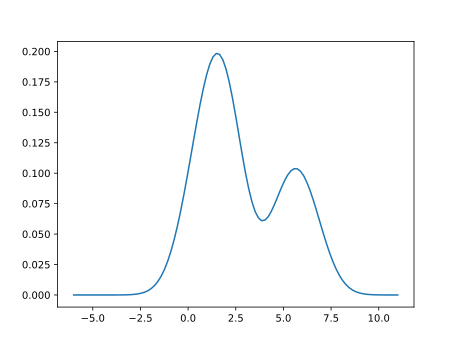

In [11]:
density [2.1, 1.3, 0.4, 1.9, 5.1, 6.2] (Just (-6, 11))

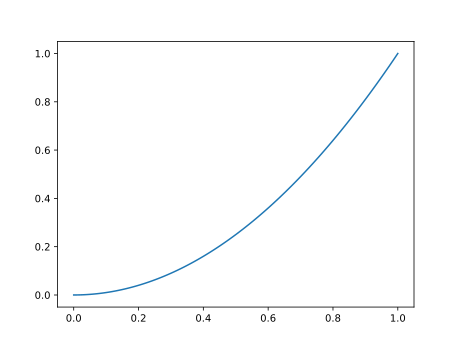

In [12]:
lineF (\x -> x**2) [0,0.01..1]

In [13]:
import IHaskell.Display
import IHaskell.Display.Magic
import Torch.Misc(setDisplay)
import Data.Dynamic
import Data.Text (Text)

In [14]:
setDisplay printDisplay printDisplay

: 

"XTRACE"
CtracerXin
CtracerXf
CtracerXfn
CtracerXten
CtracerXcallback
CtracerXcallbackret
CtracerXfnret
XXState has N references 1
XXState has N references 2

               weights & biases:
LinearParam -0.4962 -0.1497  0.5139 -0.5499  0.4377
 0.4087  0.4209 -0.1319  0.3162 -0.6904
[ CPUDoubleType{2,5} ] Just -0.3442
-0.4403
[ CPUDoubleType{2} ]
               Loss: 1.4673257806500266
graph(%0 : Double(7, 5, strides=[5, 1], requires_grad=0, device=cpu),
      %1 : Double(7, 2, strides=[2, 1], requires_grad=0, device=cpu)):
  %2 : Double(2, 5, strides=[5, 1], requires_grad=0, device=cpu) = prim::Constant[value=-0.4962 -0.1497  0.5139 -0.5499  0.4377  0.4087  0.4209 -0.1319  0.3162 -0.6904 [ CPUDoubleType{2,5} ]]()
  %3 : Double(5, 2, strides=[1, 5], requires_grad=0, device=cpu) = aten::t(%2)
  %4 : Double(2, strides=[1], requires_grad=0, device=cpu) = prim::Constant[value=-0.3442 -0.4403 [ CPUDoubleType{2} ]]()
  %5 : int = prim::Constant[value=7]()
  %6 : int = prim::Constant[value=2]

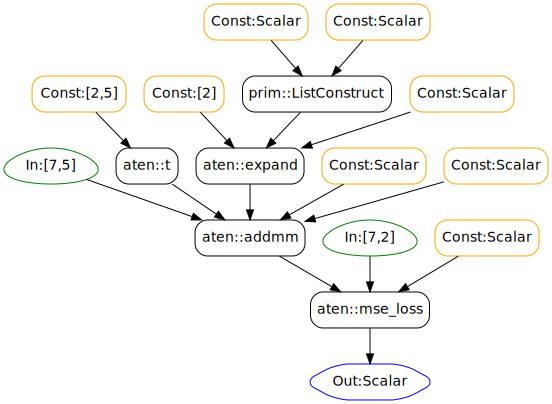

In [15]:
ex8

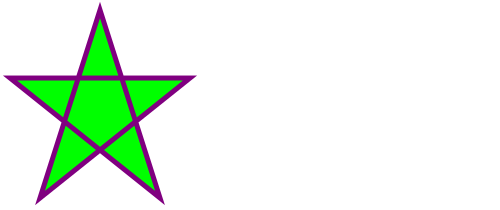

1

In [23]:
display ("<svg height=\"210\" width=\"500\"><polygon points=\"100,10 40,198 190,78 10,78 160,198\" style=\"fill:lime;stroke:purple;stroke-width:5;fill-rule:nonzero;\"/>Sorry, your browser does not support inline SVG.</svg>" :: Text)
display ("1" :: Text)